In [ ]:
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn accelerate

In [ ]:
import numpy as np
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import KFold
import torch
import warnings
warnings.filterwarnings('ignore')
from google.colab import userdata
hf_token = userdata.get('huggingface')
login(hf_token)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
dataset = load_dataset("Zlovoblachko/DeepSeek_dim4")

README.md:   0%|          | 0.00/596 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1081 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/136 [00:00<?, ? examples/s]

In [ ]:
print("Dataset splits:")
print(dataset)
print("\nSample from training set:")
print(dataset['train'][0])
print("\nColumn names:")
print(dataset['train'].column_names)

Dataset splits:
DatasetDict({
    train: Dataset({
        features: ['Previous sentence', 'Target sentence', 'Label', '__index_level_0__'],
        num_rows: 1081
    })
    dev: Dataset({
        features: ['Previous sentence', 'Target sentence', 'Label', '__index_level_0__'],
        num_rows: 135
    })
    test: Dataset({
        features: ['Previous sentence', 'Target sentence', 'Label', '__index_level_0__'],
        num_rows: 136
    })
})

Sample from training set:
{'Previous sentence': 'Without viewers support any game will become boring and painful for atheletes, who tries to may out spending of time more interesting.', 'Target sentence': "It is not empty because a lot of sportsmen claimed that a lot of their wins were get due to the peoples support from the viewer's seats.", 'Label': 'H', '__index_level_0__': 459}

Column names:
['Previous sentence', 'Target sentence', 'Label', '__index_level_0__']


In [ ]:
train_labels = [item['Label'] for item in dataset['train']]
val_labels = [item['Label'] for item in dataset['dev']]
test_labels = [item['Label'] for item in dataset['test']]

In [ ]:
print(f"Training set - H: {train_labels.count('H')}, L: {train_labels.count('L')}")
print(f"Validation set - H: {val_labels.count('H')}, L: {val_labels.count('L')}")
print(f"Test set - H: {test_labels.count('H')}, L: {test_labels.count('L')}")

Training set - H: 560, L: 521
Validation set - H: 70, L: 65
Test set - H: 70, L: 66


In [ ]:
column_combinations = {
    'target_only': ['Target sentence'],
    'all_columns': ['Previous sentence', 'Target sentence']
}

In [ ]:
print("Column combinations for ablation study:")
for name, cols in column_combinations.items():
    print(f"{name}: {cols}")

Column combinations for ablation study:
target_only: ['Target sentence']
all_columns: ['Previous sentence', 'Target sentence']


In [ ]:
def concatenate_columns(example, columns):
    """Concatenate specified columns with [SEP] token"""
    texts = []
    for col in columns:
        if example[col] and str(example[col]).strip():
            texts.append(str(example[col]).strip())
    return ' [SEP] '.join(texts)

In [ ]:
def prepare_dataset(dataset_split, columns, tokenizer, max_length=512):
    """Tokenize and prepare dataset"""
    texts = [concatenate_columns(example, columns) for example in dataset_split]
    labels = [1 if example['Label'] == 'H' else 0 for example in dataset_split]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels)
    }

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    """PyTorch Dataset wrapper"""
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['labels'][idx]
        }

    def __len__(self):
        return len(self.encodings['labels'])

In [ ]:
def compute_metrics(pred):
    """Compute evaluation metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def cross_validate_model(model_name, train_dataset, columns, n_folds=5):
    """Perform k-fold cross-validation and return metrics with CI"""
    print(f"\n{'='*60}")
    print(f"Cross-validating {model_name} with columns: {columns}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare data
    texts = [concatenate_columns(example, columns) for example in train_dataset]
    labels = np.array([1 if example['Label'] == 'H' else 0 for example in train_dataset])

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    fold_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': []
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(texts)):
        print(f"\nFold {fold + 1}/{n_folds}")

        # Split data
        train_texts = [texts[i] for i in train_idx]
        train_labels = labels[train_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = labels[val_idx]

        # Tokenize
        train_encodings = tokenizer(train_texts, truncation=True, padding='max_length',
                                    max_length=512, return_tensors='pt')
        val_encodings = tokenizer(val_texts, truncation=True, padding='max_length',
                                  max_length=512, return_tensors='pt')

        train_data = TextDataset({
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask'],
            'labels': torch.tensor(train_labels)
        })

        val_data = TextDataset({
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'labels': torch.tensor(val_labels)
        })

        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f'./results_{model_name.split("/")[-1]}_fold{fold}',
            num_train_epochs=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            weight_decay=0.01,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            logging_dir='./logs',
            logging_steps=10,
            seed=42
        )

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            compute_metrics=compute_metrics
        )

        # Train
        trainer.train()

        # Evaluate
        results = trainer.evaluate()

        fold_metrics['accuracy'].append(results['eval_accuracy'])
        fold_metrics['f1'].append(results['eval_f1'])
        fold_metrics['precision'].append(results['eval_precision'])
        fold_metrics['recall'].append(results['eval_recall'])

        print(f"Fold {fold + 1} Results:")
        print(f"  Accuracy: {results['eval_accuracy']:.4f}")
        print(f"  F1: {results['eval_f1']:.4f}")
        print(f"  Precision: {results['eval_precision']:.4f}")
        print(f"  Recall: {results['eval_recall']:.4f}")

    # Calculate statistics
    stats = {}
    for metric, values in fold_metrics.items():
        values_array = np.array(values)
        mean = values_array.mean()
        std = values_array.std()
        # 95% confidence interval
        ci_lower = mean - 1.96 * (std / np.sqrt(n_folds))
        ci_upper = mean + 1.96 * (std / np.sqrt(n_folds))

        stats[metric] = {
            'mean': mean,
            'std': std,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'all_folds': values
        }

    print(f"\n{'='*60}")
    print(f"Cross-Validation Summary for {model_name}")
    print(f"{'='*60}")
    for metric, stat in stats.items():
        print(f"{metric.capitalize()}:")
        print(f"  Mean: {stat['mean']:.4f}")
        print(f"  Std: {stat['std']:.4f}")
        print(f"  95% CI: [{stat['ci_lower']:.4f}, {stat['ci_upper']:.4f}]")

    return stats, fold_metrics

In [ ]:
def train_and_evaluate_best_model(model_name, train_dataset, val_dataset, test_dataset, columns):
    """Train model on full training set and evaluate on test set"""
    print(f"\n{'='*60}")
    print(f"Training {model_name} on full training set")
    print(f"Columns: {columns}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_data = prepare_dataset(train_dataset, columns, tokenizer)
    val_data = prepare_dataset(val_dataset, columns, tokenizer)
    test_data = prepare_dataset(test_dataset, columns, tokenizer)

    train_dataset_obj = TextDataset(train_data)
    val_dataset_obj = TextDataset(val_data)
    test_dataset_obj = TextDataset(test_data)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{model_name.split("/")[-1]}_best',
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        logging_dir='./logs',
        logging_steps=10,
        seed=42
    )

    # Trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_obj,
        eval_dataset=val_dataset_obj,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()

    # Evaluate on test set
    test_results = trainer.evaluate(test_dataset_obj)

    # Get predictions for detailed analysis
    predictions = trainer.predict(test_dataset_obj)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = test_data['labels'].numpy()

    print(f"\n{'='*60}")
    print(f"Test Set Results for {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"F1: {test_results['eval_f1']:.4f}")
    print(f"Precision: {test_results['eval_precision']:.4f}")
    print(f"Recall: {test_results['eval_recall']:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['L', 'H']))

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    return {
        'test_results': test_results,
        'predictions': pred_labels,
        'true_labels': true_labels,
        'confusion_matrix': cm,
        'model': model,
        'trainer': trainer
    }

In [ ]:
model_names = [
    'bert-base-uncased',
    'roberta-base',
    'answerdotai/ModernBERT-base'
]

In [ ]:
cv_results = {}

In [ ]:
selected_columns = column_combinations['target_only']

In [ ]:
for model_name in model_names:
    try:
        stats, fold_metrics = cross_validate_model(
            model_name,
            dataset['train'],
            selected_columns,
            n_folds=3
        )
        cv_results[model_name] = {
            'stats': stats,
            'fold_metrics': fold_metrics
        }
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        continue


Cross-validating bert-base-uncased with columns: ['Target sentence']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Fold 1/3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zlovoblachko to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.680800,0.640407,0.662050,0.657377,0.663405,0.662050
2,0.505600,0.633616,0.678670,0.675078,0.679851,0.678670
3,0.456600,0.672989,0.650970,0.650761,0.657346,0.650970


Fold 1 Results:
  Accuracy: 0.6787
  F1: 0.6751
  Precision: 0.6799
  Recall: 0.6787

Fold 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.598400,0.605646,0.680556,0.680045,0.685127,0.680556
2,0.515000,0.611520,0.705556,0.705392,0.708768,0.705556
3,0.339900,0.621014,0.705556,0.705483,0.705453,0.705556


Fold 2 Results:
  Accuracy: 0.7056
  F1: 0.7055
  Precision: 0.7055
  Recall: 0.7056

Fold 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.641000,0.640687,0.638889,0.630781,0.639078,0.638889
2,0.470800,0.646803,0.658333,0.652679,0.658443,0.658333
3,0.389300,0.692071,0.652778,0.653113,0.659765,0.652778


Fold 3 Results:
  Accuracy: 0.6528
  F1: 0.6531
  Precision: 0.6598
  Recall: 0.6528

Cross-Validation Summary for bert-base-uncased
Accuracy:
  Mean: 0.6790
  Std: 0.0215
  95% CI: [0.6546, 0.7034]
F1:
  Mean: 0.6779
  Std: 0.0215
  95% CI: [0.6536, 0.7022]
Precision:
  Mean: 0.6817
  Std: 0.0187
  95% CI: [0.6605, 0.7028]
Recall:
  Mean: 0.6790
  Std: 0.0215
  95% CI: [0.6546, 0.7034]

Cross-validating roberta-base with columns: ['Target sentence']


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Fold 1/3


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.710300,0.686478,0.531856,0.369318,0.282871,0.531856
2,0.571700,0.616684,0.670360,0.670162,0.670056,0.670360
3,0.557200,0.650575,0.662050,0.662362,0.663323,0.662050


Fold 1 Results:
  Accuracy: 0.6704
  F1: 0.6702
  Precision: 0.6701
  Recall: 0.6704

Fold 2/3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.695800,0.702266,0.480556,0.311955,0.230934,0.480556
2,0.623900,0.611153,0.666667,0.666770,0.667037,0.666667
3,0.472300,0.582150,0.708333,0.703578,0.716168,0.708333


Fold 2 Results:
  Accuracy: 0.7083
  F1: 0.7036
  Precision: 0.7162
  Recall: 0.7083

Fold 3/3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.713500,0.668822,0.608333,0.608421,0.616453,0.608333
2,0.568700,0.615557,0.672222,0.672487,0.672917,0.672222
3,0.529900,0.657579,0.652778,0.652513,0.663323,0.652778


Fold 3 Results:
  Accuracy: 0.6722
  F1: 0.6725
  Precision: 0.6729
  Recall: 0.6722

Cross-Validation Summary for roberta-base
Accuracy:
  Mean: 0.6836
  Std: 0.0175
  95% CI: [0.6639, 0.7034]
F1:
  Mean: 0.6821
  Std: 0.0152
  95% CI: [0.6648, 0.6993]
Precision:
  Mean: 0.6864
  Std: 0.0211
  95% CI: [0.6625, 0.7103]
Recall:
  Mean: 0.6836
  Std: 0.0175
  95% CI: [0.6639, 0.7034]

Cross-validating answerdotai/ModernBERT-base with columns: ['Target sentence']


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]


Fold 1/3


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1130 23:13:44.276000 224 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.674300,0.621576,0.689751,0.689492,0.689403,0.689751
2,0.437600,0.625439,0.700831,0.701088,0.704101,0.700831
3,0.337800,0.740113,0.720222,0.720493,0.721658,0.720222


Fold 1 Results:
  Accuracy: 0.7202
  F1: 0.7205
  Precision: 0.7217
  Recall: 0.7202

Fold 2/3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.597500,0.621964,0.641667,0.631631,0.669583,0.641667
2,0.445200,0.602940,0.680556,0.679689,0.686556,0.680556
3,0.143200,0.693266,0.708333,0.706113,0.710856,0.708333


Fold 2 Results:
  Accuracy: 0.7083
  F1: 0.7061
  Precision: 0.7109
  Recall: 0.7083

Fold 3/3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.661300,0.656052,0.608333,0.581021,0.616268,0.608333
2,0.471300,0.650755,0.666667,0.648155,0.683548,0.666667
3,0.300300,0.692082,0.705556,0.706048,0.708106,0.705556


Fold 3 Results:
  Accuracy: 0.7056
  F1: 0.7060
  Precision: 0.7081
  Recall: 0.7056

Cross-Validation Summary for answerdotai/ModernBERT-base
Accuracy:
  Mean: 0.7114
  Std: 0.0064
  95% CI: [0.7042, 0.7186]
F1:
  Mean: 0.7109
  Std: 0.0068
  95% CI: [0.7032, 0.7186]
Precision:
  Mean: 0.7135
  Std: 0.0058
  95% CI: [0.7069, 0.7202]
Recall:
  Mean: 0.7114
  Std: 0.0064
  95% CI: [0.7042, 0.7186]


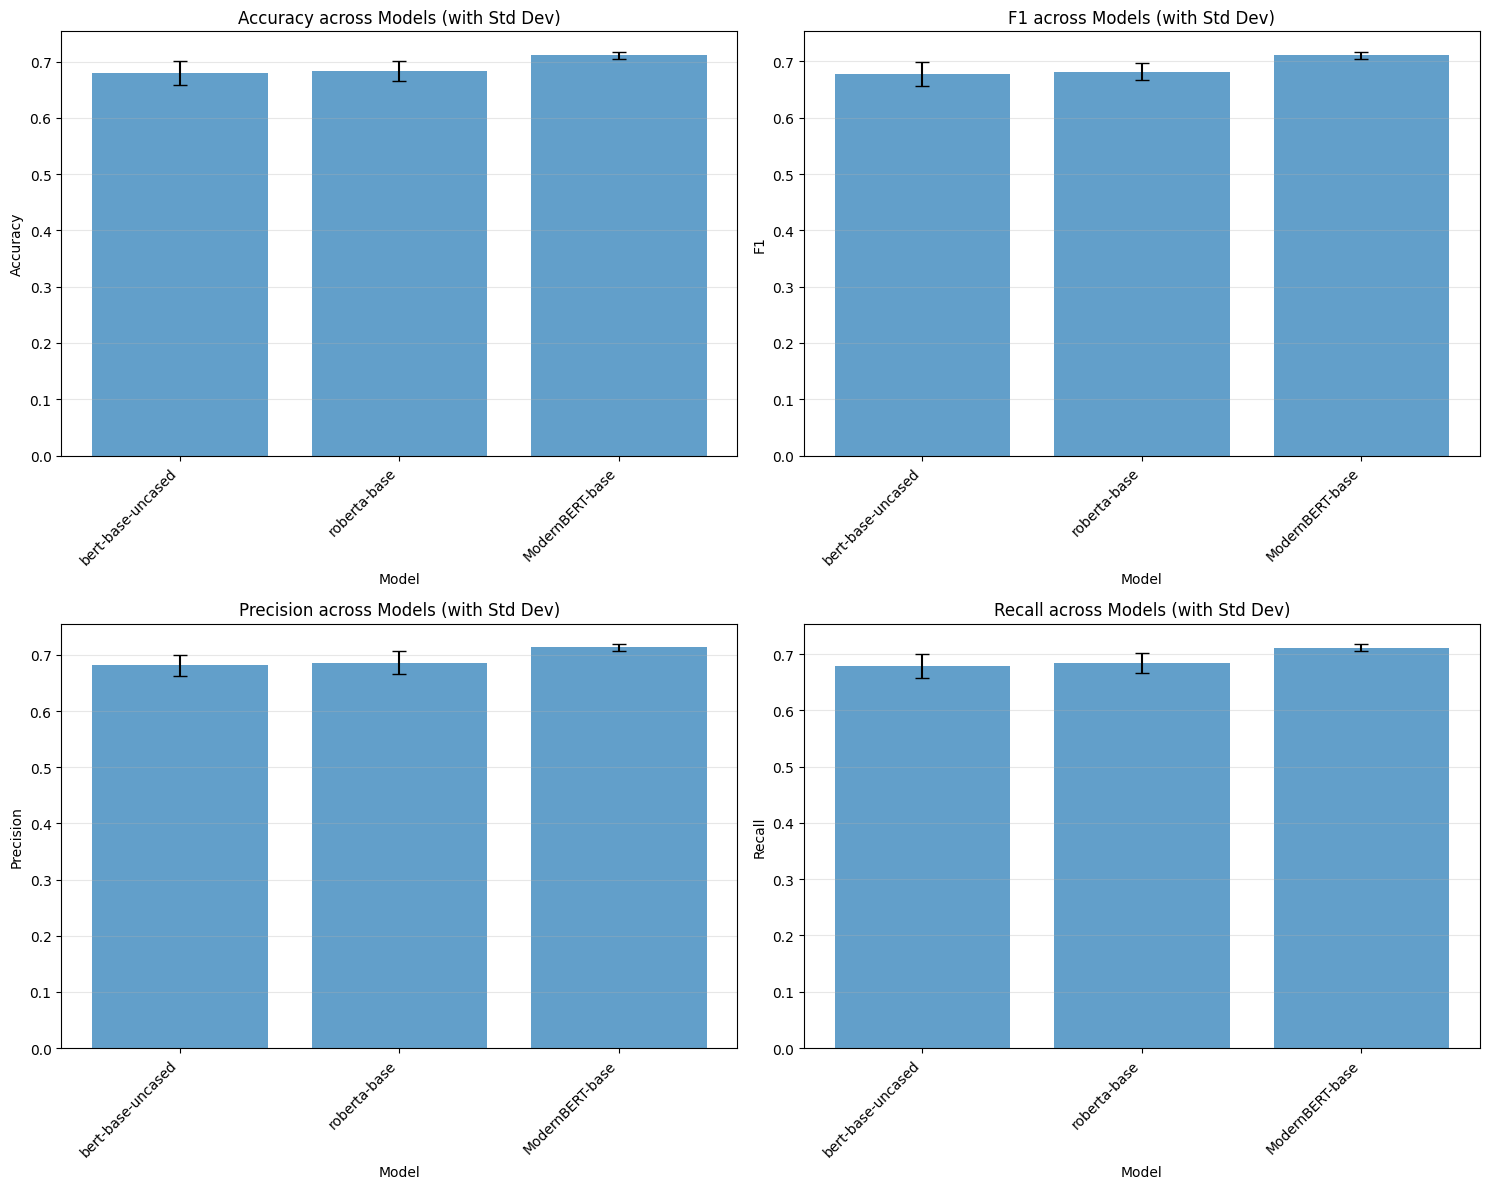

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['accuracy', 'f1', 'precision', 'recall']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    model_names_list = list(cv_results.keys())
    means = [cv_results[m]['stats'][metric]['mean'] for m in model_names_list]
    stds = [cv_results[m]['stats'][metric]['std'] for m in model_names_list]

    x_pos = np.arange(len(model_names_list))
    ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} across Models (with Std Dev)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.split('/')[-1] for m in model_names_list], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
summary_data = []
for model_name, results in cv_results.items():
    for metric in ['accuracy', 'f1', 'precision', 'recall']:
        stats = results['stats'][metric]
        summary_data.append({
            'Model': model_name.split('/')[-1],
            'Metric': metric.capitalize(),
            'Mean': f"{stats['mean']:.4f}",
            'Std': f"{stats['std']:.4f}",
            '95% CI': f"[{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]"
        })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))


CROSS-VALIDATION SUMMARY TABLE
            Model    Metric   Mean    Std           95% CI
bert-base-uncased  Accuracy 0.6790 0.0215 [0.6546, 0.7034]
bert-base-uncased        F1 0.6779 0.0215 [0.6536, 0.7022]
bert-base-uncased Precision 0.6817 0.0187 [0.6605, 0.7028]
bert-base-uncased    Recall 0.6790 0.0215 [0.6546, 0.7034]
     roberta-base  Accuracy 0.6836 0.0175 [0.6639, 0.7034]
     roberta-base        F1 0.6821 0.0152 [0.6648, 0.6993]
     roberta-base Precision 0.6864 0.0211 [0.6625, 0.7103]
     roberta-base    Recall 0.6836 0.0175 [0.6639, 0.7034]
  ModernBERT-base  Accuracy 0.7114 0.0064 [0.7042, 0.7186]
  ModernBERT-base        F1 0.7109 0.0068 [0.7032, 0.7186]
  ModernBERT-base Precision 0.7135 0.0058 [0.7069, 0.7202]
  ModernBERT-base    Recall 0.7114 0.0064 [0.7042, 0.7186]


In [ ]:
best_model_name = max(cv_results.keys(),
                      key=lambda x: cv_results[x]['stats']['f1']['mean'])
print(f"\nBest performing model: {best_model_name}")
print(f"Mean F1 score: {cv_results[best_model_name]['stats']['f1']['mean']:.4f}")


Best performing model: answerdotai/ModernBERT-base
Mean F1 score: 0.7109


In [ ]:
best_model_results = train_and_evaluate_best_model(
    best_model_name,
    dataset['train'],
    dataset['dev'],
    dataset['test'],
    selected_columns
)


Training answerdotai/ModernBERT-base on full training set
Columns: ['Target sentence']


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.698500,0.682525,0.637037,0.606472,0.680247,0.637037
2,0.336600,0.746778,0.607407,0.607537,0.608266,0.607407
3,0.226200,1.361279,0.577778,0.576246,0.582466,0.577778
4,0.013000,1.694616,0.629630,0.629630,0.629630,0.629630
5,0.000100,1.720987,0.614815,0.614051,0.614368,0.614815



Test Set Results for answerdotai/ModernBERT-base
Accuracy: 0.6765
F1: 0.6754
Precision: 0.6818
Recall: 0.6765

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.64      0.74      0.69        66
           H       0.72      0.61      0.66        70

    accuracy                           0.68       136
   macro avg       0.68      0.68      0.68       136
weighted avg       0.68      0.68      0.68       136



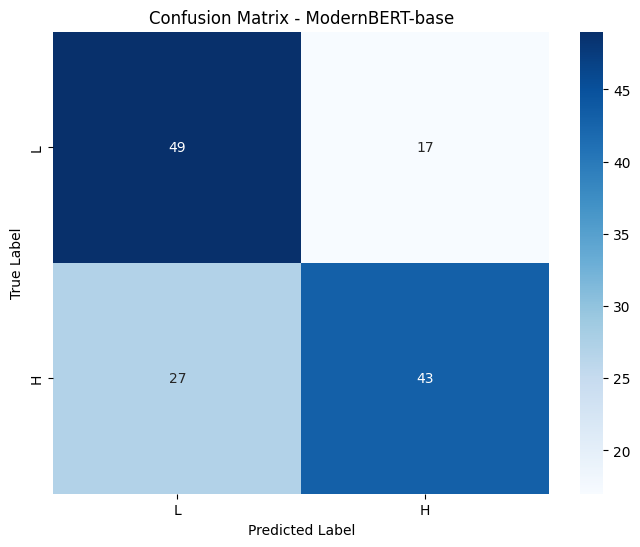

In [ ]:
plt.figure(figsize=(8, 6))
cm = best_model_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['L', 'H'], yticklabels=['L', 'H'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name.split("/")[-1]}')
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY: COLUMN COMBINATIONS")
print("="*80)

ablation_results = {}

for combo_name, columns in column_combinations.items():
    print(f"\nTesting combination: {combo_name}")
    print(f"Columns: {columns}")

    try:
        results = train_and_evaluate_best_model(
            best_model_name,
            dataset['train'],
            dataset['dev'],
            dataset['test'],
            columns
        )

        ablation_results[combo_name] = {
            'columns': columns,
            'accuracy': results['test_results']['eval_accuracy'],
            'f1': results['test_results']['eval_f1'],
            'precision': results['test_results']['eval_precision'],
            'recall': results['test_results']['eval_recall']
        }
    except Exception as e:
        print(f"Error with {combo_name}: {str(e)}")
        continue


ABLATION STUDY: COLUMN COMBINATIONS

Testing combination: target_only
Columns: ['Target sentence']

Training answerdotai/ModernBERT-base on full training set
Columns: ['Target sentence']


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.693200,0.707342,0.592593,0.562148,0.612988,0.592593
2,0.422600,0.725027,0.600000,0.594044,0.601307,0.600000
3,0.199100,1.138451,0.629630,0.629630,0.629630,0.629630
4,0.026000,1.903637,0.592593,0.591787,0.596285,0.592593
5,0.000600,1.876096,0.607407,0.606889,0.606970,0.607407



Test Set Results for answerdotai/ModernBERT-base
Accuracy: 0.6985
F1: 0.6973
Precision: 0.7053
Recall: 0.6985

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.66      0.77      0.71        66
           H       0.75      0.63      0.68        70

    accuracy                           0.70       136
   macro avg       0.70      0.70      0.70       136
weighted avg       0.71      0.70      0.70       136


Testing combination: all_columns
Columns: ['Previous sentence', 'Target sentence']

Training answerdotai/ModernBERT-base on full training set
Columns: ['Previous sentence', 'Target sentence']


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.501200,0.583084,0.718519,0.708962,0.741340,0.718519
2,0.357200,0.591003,0.733333,0.727095,0.748711,0.733333
3,0.104500,1.048929,0.792593,0.790864,0.798064,0.792593
4,0.001600,1.331144,0.792593,0.792593,0.792593,0.792593
5,0.000100,1.457986,0.777778,0.776968,0.779265,0.777778



Test Set Results for answerdotai/ModernBERT-base
Accuracy: 0.8162
F1: 0.8160
Precision: 0.8201
Recall: 0.8162

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.78      0.86      0.82        66
           H       0.86      0.77      0.81        70

    accuracy                           0.82       136
   macro avg       0.82      0.82      0.82       136
weighted avg       0.82      0.82      0.82       136



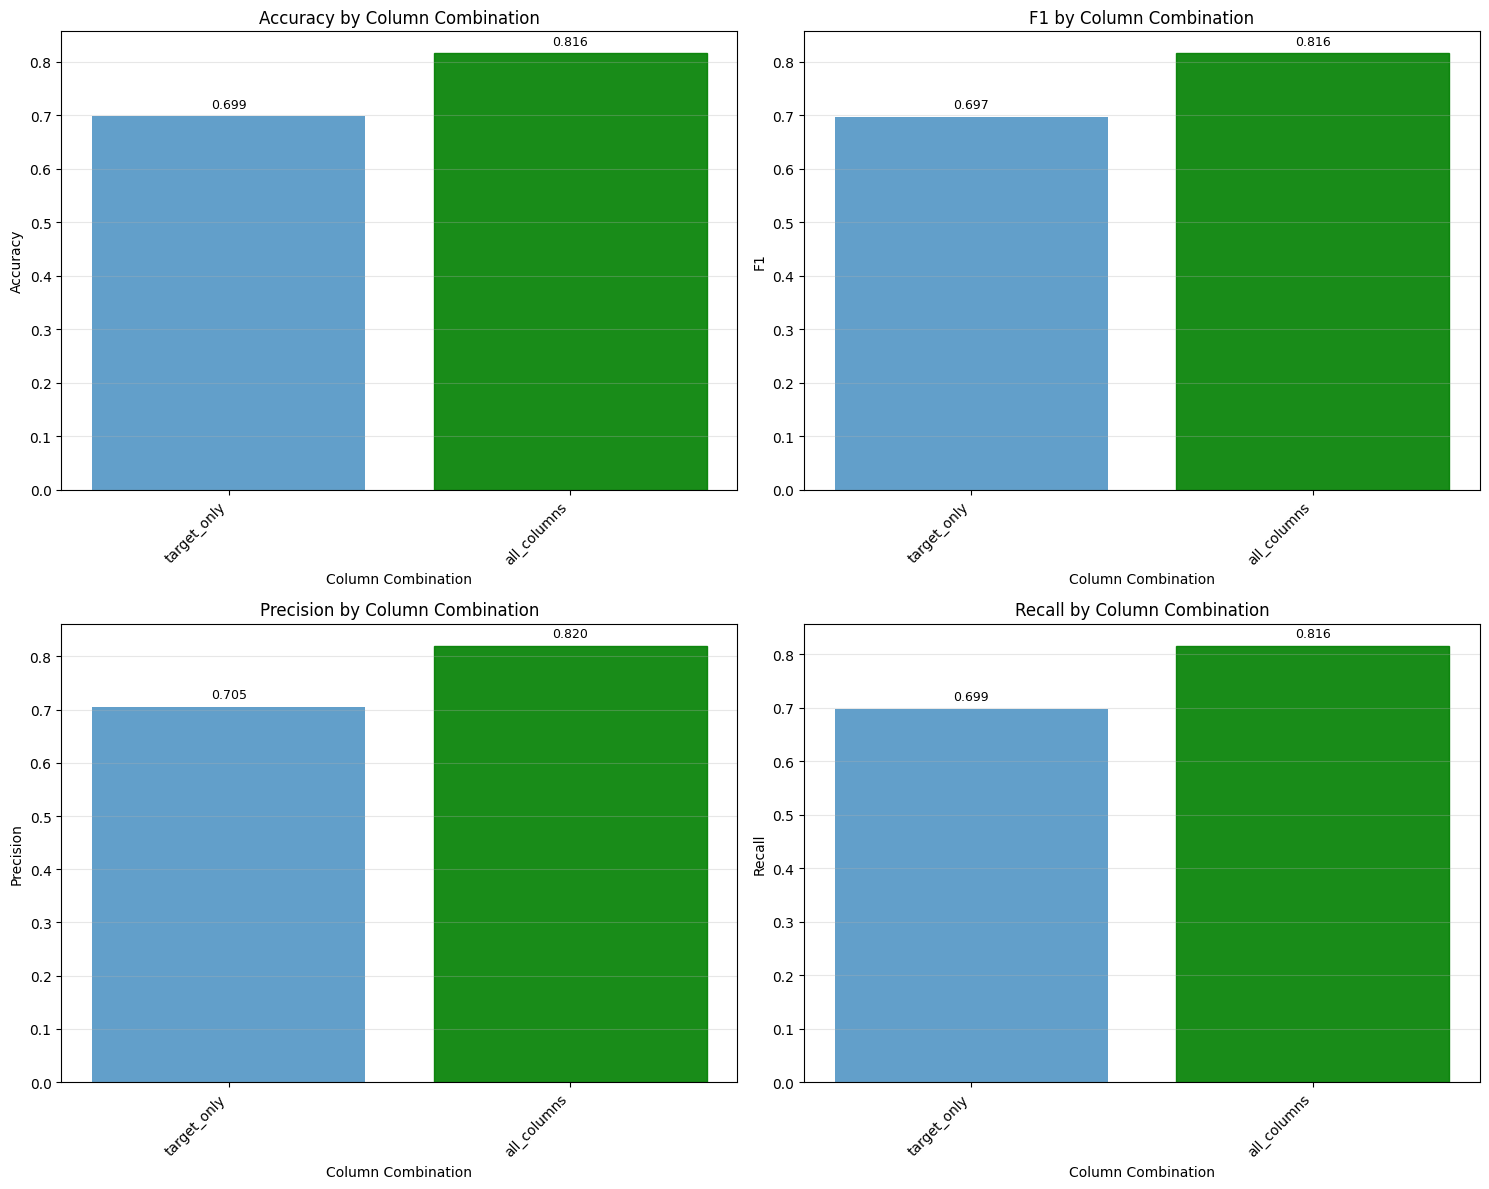

In [ ]:
ablation_df = pd.DataFrame(ablation_results).T
ablation_df = ablation_df.reset_index().rename(columns={'index': 'combination'})

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics_plot = ['accuracy', 'f1', 'precision', 'recall']

for idx, metric in enumerate(metrics_plot):
    ax = axes[idx // 2, idx % 2]

    x_pos = np.arange(len(ablation_df))
    values = ablation_df[metric].values

    bars = ax.bar(x_pos, values, alpha=0.7)

    # Color the bar with highest value
    max_idx = values.argmax()
    bars[max_idx].set_color('green')
    bars[max_idx].set_alpha(0.9)

    ax.set_xlabel('Column Combination')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by Column Combination')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ablation_df['combination'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('ablation_column_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY: COLUMN COMBINATIONS")
print("="*80)
print(ablation_df.to_string(index=False))

# Find best combination for each metric
print("\nBest combinations per metric:")
for metric in metrics_plot:
    best_combo = ablation_df.loc[ablation_df[metric].idxmax(), 'combination']
    best_value = ablation_df[metric].max()
    print(f"{metric.capitalize()}: {best_combo} ({best_value:.4f})")


ABLATION STUDY SUMMARY: COLUMN COMBINATIONS
combination                              columns  accuracy        f1 precision    recall
target_only                    [Target sentence]  0.698529  0.697271  0.705277  0.698529
all_columns [Previous sentence, Target sentence]  0.816176  0.815968  0.820105  0.816176

Best combinations per metric:
Accuracy: all_columns (0.8162)
F1: all_columns (0.8160)
Precision: all_columns (0.8201)
Recall: all_columns (0.8162)


In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY: LAYER FREEZING")
print("="*80)

def train_with_frozen_layers(model_name, train_dataset, val_dataset, test_dataset,
                             columns, n_layers_to_freeze=0):
    """Train model with specified number of frozen layers"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_data = prepare_dataset(train_dataset, columns, tokenizer)
    val_data = prepare_dataset(val_dataset, columns, tokenizer)
    test_data = prepare_dataset(test_dataset, columns, tokenizer)

    train_dataset_obj = TextDataset(train_data)
    val_dataset_obj = TextDataset(val_data)
    test_dataset_obj = TextDataset(test_data)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Freeze layers
    if n_layers_to_freeze > 0:
        # For BERT/RoBERTa, encoder layers are in model.bert.encoder.layer or model.roberta.encoder.layer
        encoder_attr = 'bert' if 'bert' in model_name else 'roberta'
        if hasattr(model, encoder_attr):
            encoder = getattr(model, encoder_attr)
            for i in range(n_layers_to_freeze):
                for param in encoder.encoder.layer[i].parameters():
                    param.requires_grad = False
            print(f"Frozen first {n_layers_to_freeze} layers")

    # Training arguments (fewer epochs for ablation)
    training_args = TrainingArguments(
        output_dir=f'./results_frozen_{n_layers_to_freeze}',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        logging_dir='./logs',
        logging_steps=10,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_obj,
        eval_dataset=val_dataset_obj,
        compute_metrics=compute_metrics
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset_obj)

    return test_results


ABLATION STUDY: LAYER FREEZING


In [ ]:
freeze_configs = [0, 3, 6]  # Number of layers to freeze
freezing_results = {}

In [ ]:
for n_freeze in freeze_configs:
    print(f"\nTesting with {n_freeze} frozen layers...")
    try:
        results = train_with_frozen_layers(
            best_model_name,
            dataset['train'],
            dataset['dev'],
            dataset['test'],
            selected_columns,
            n_freeze
        )

        freezing_results[n_freeze] = {
            'accuracy': results['eval_accuracy'],
            'f1': results['eval_f1'],
            'precision': results['eval_precision'],
            'recall': results['eval_recall']
        }

        print(f"Results with {n_freeze} frozen layers:")
        print(f"  Accuracy: {results['eval_accuracy']:.4f}")
        print(f"  F1: {results['eval_f1']:.4f}")
    except Exception as e:
        print(f"Error with {n_freeze} frozen layers: {str(e)}")
        continue


Testing with 0 frozen layers...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689000,0.660025,0.607407,0.592911,0.616175,0.607407
2,0.435500,0.731446,0.622222,0.617284,0.624163,0.622222
3,0.278500,0.918569,0.592593,0.592593,0.594221,0.592593


Results with 0 frozen layers:
  Accuracy: 0.7279
  F1: 0.7268

Testing with 3 frozen layers...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.687300,0.648292,0.644444,0.616220,0.686862,0.644444
2,0.447000,0.652162,0.651852,0.642857,0.661202,0.651852
3,0.281700,0.763729,0.644444,0.643148,0.644415,0.644444


Results with 3 frozen layers:
  Accuracy: 0.7279
  F1: 0.7280

Testing with 6 frozen layers...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.764800,0.663104,0.637037,0.627659,0.644909,0.637037
2,0.402400,0.712378,0.637037,0.625744,0.647371,0.637037
3,0.206000,0.861220,0.629630,0.628895,0.629269,0.629630


Results with 6 frozen layers:
  Accuracy: 0.7206
  F1: 0.7197


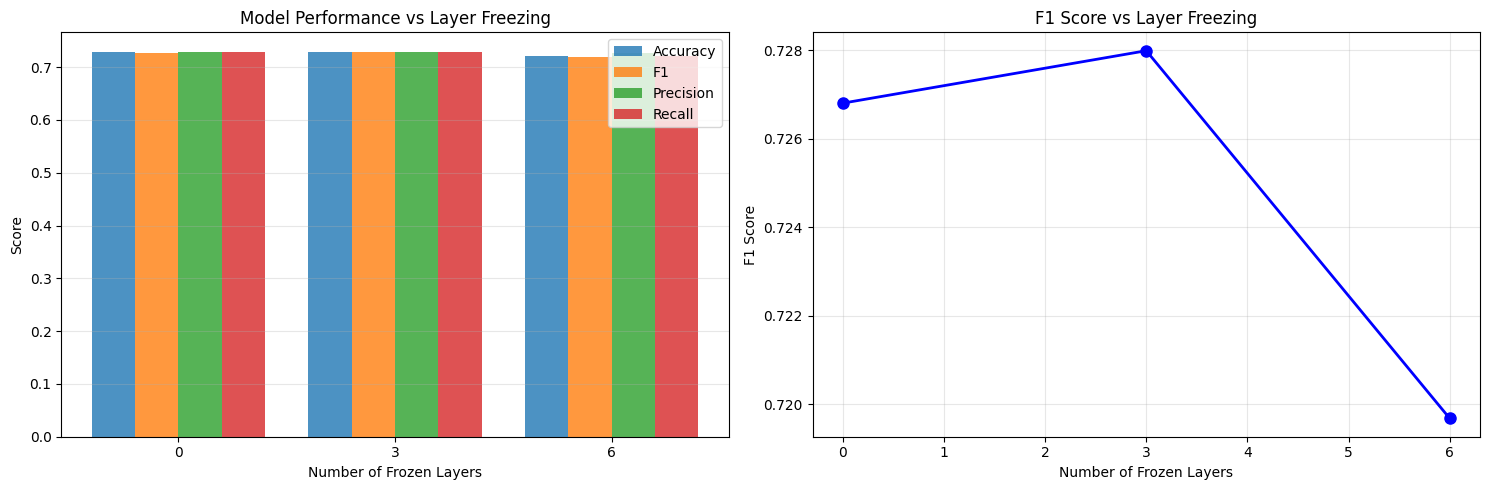

In [ ]:
freezing_df = pd.DataFrame(freezing_results).T
freezing_df = freezing_df.reset_index().rename(columns={'index': 'frozen_layers'})
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All metrics
ax1 = axes[0]
x_pos = np.arange(len(freezing_df))
width = 0.2

for i, metric in enumerate(['accuracy', 'f1', 'precision', 'recall']):
    ax1.bar(x_pos + i * width, freezing_df[metric], width,
            label=metric.capitalize(), alpha=0.8)

ax1.set_xlabel('Number of Frozen Layers')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance vs Layer Freezing')
ax1.set_xticks(x_pos + width * 1.5)
ax1.set_xticklabels(freezing_df['frozen_layers'].astype(int))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: F1 score focus
ax2 = axes[1]
ax2.plot(freezing_df['frozen_layers'], freezing_df['f1'], marker='o',
         linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Number of Frozen Layers')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Layer Freezing')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_layer_freezing.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Cell 22: Print layer freezing summary
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY: LAYER FREEZING")
print("="*80)
print(freezing_df.to_string(index=False))

print("\nBest configuration:")
best_freeze = freezing_df.loc[freezing_df['f1'].idxmax(), 'frozen_layers']
best_f1 = freezing_df['f1'].max()
print(f"Frozen layers: {int(best_freeze)}, F1 score: {best_f1:.4f}")


ABLATION STUDY SUMMARY: LAYER FREEZING
 frozen_layers  accuracy       f1  precision   recall
             0  0.727941 0.726801   0.729561 0.727941
             3  0.727941 0.727985   0.728738 0.727941
             6  0.720588 0.719680   0.726651 0.720588

Best configuration:
Frozen layers: 3, F1 score: 0.7280


In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n1. BEST MODEL (from cross-validation):")
print(f"   Model: {best_model_name}")
print(f"   Mean F1: {cv_results[best_model_name]['stats']['f1']['mean']:.4f}")
print(f"   Std: {cv_results[best_model_name]['stats']['f1']['std']:.4f}")
print(f"   95% CI: [{cv_results[best_model_name]['stats']['f1']['ci_lower']:.4f}, "
      f"{cv_results[best_model_name]['stats']['f1']['ci_upper']:.4f}]")

print("\n2. BEST COLUMN COMBINATION:")
best_combo = ablation_df.loc[ablation_df['f1'].idxmax(), 'combination']
best_combo_f1 = ablation_df['f1'].max()
best_combo_cols = column_combinations[best_combo]
print(f"   Combination: {best_combo}")
print(f"   Columns: {best_combo_cols}")
print(f"   F1 score: {best_combo_f1:.4f}")

print("\n3. OPTIMAL LAYER FREEZING:")
print(f"   Frozen layers: {int(best_freeze)}")
print(f"   F1 score: {best_f1:.4f}")

print("\n4. KEY INSIGHTS:")
# Compare target_only vs all_columns
if 'target_only' in ablation_results and 'all_columns' in ablation_results:
    target_only_f1 = ablation_results['target_only']['f1']
    all_cols_f1 = ablation_results['all_columns']['f1']
    improvement = ((all_cols_f1 - target_only_f1) / target_only_f1) * 100

    print(f"   - Adding contextual columns improved F1 by {improvement:.2f}%")
    print(f"     (from {target_only_f1:.4f} to {all_cols_f1:.4f})")

# Compare full fine-tuning vs freezing
if 0 in freezing_results and len(freezing_results) > 1:
    full_finetune_f1 = freezing_results[0]['f1']
    frozen_f1_values = [v['f1'] for k, v in freezing_results.items() if k > 0]
    if frozen_f1_values:
        best_frozen_f1 = max(frozen_f1_values)
        if best_frozen_f1 >= full_finetune_f1 * 0.98:  # Within 2%
            print(f"   - Layer freezing achieves comparable performance")
            print(f"     (reduces training time without significant F1 loss)")

print("\n" + "="*80)
print("Analysis complete! All results saved to PNG files.")
print("="*80)


FINAL SUMMARY AND RECOMMENDATIONS

1. BEST MODEL (from cross-validation):
   Model: answerdotai/ModernBERT-base
   Mean F1: 0.7109
   Std: 0.0068
   95% CI: [0.7032, 0.7186]

2. BEST COLUMN COMBINATION:
   Combination: all_columns
   Columns: ['Previous sentence', 'Target sentence']
   F1 score: 0.8160

3. OPTIMAL LAYER FREEZING:
   Frozen layers: 3
   F1 score: 0.7280

4. KEY INSIGHTS:
   - Adding contextual columns improved F1 by 17.02%
     (from 0.6973 to 0.8160)
   - Layer freezing achieves comparable performance
     (reduces training time without significant F1 loss)

Analysis complete! All results saved to PNG files.


In [ ]:
# Train final model with best configuration
print("\nTraining final model with optimal configuration...")

final_model_results = train_and_evaluate_best_model(
    best_model_name,
    dataset['train'],
    dataset['dev'],
    dataset['test'],
    best_combo_cols
)


Training final model with optimal configuration...

Training answerdotai/ModernBERT-base on full training set
Columns: ['Previous sentence', 'Target sentence']


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.551600,0.651751,0.659259,0.632211,0.707380,0.659259
2,0.309800,0.777947,0.688889,0.672113,0.723724,0.688889
3,0.260500,1.237660,0.755556,0.750402,0.770754,0.755556
4,0.001900,1.398333,0.792593,0.791398,0.795871,0.792593
5,0.000200,1.458660,0.785185,0.784187,0.787472,0.785185



Test Set Results for answerdotai/ModernBERT-base
Accuracy: 0.8235
F1: 0.8230
Precision: 0.8256
Recall: 0.8235

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.85      0.77      0.81        66
           H       0.80      0.87      0.84        70

    accuracy                           0.82       136
   macro avg       0.83      0.82      0.82       136
weighted avg       0.83      0.82      0.82       136



In [ ]:
save_directory = './best_model_for_inference'

print(f"\nSaving model to: {save_directory}")
final_model_results['trainer'].save_model(save_directory)

# Also save the tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_name)
tokenizer.save_pretrained(save_directory)

print(f"✓ Model saved successfully!")
print(f"✓ Tokenizer saved successfully!")

# Save configuration info
import json

config_info = {
    'model_name': best_model_name,
    'best_columns': best_combo_cols,
    'column_combination_name': best_combo,
    'test_accuracy': float(final_model_results['test_results']['eval_accuracy']),
    'test_f1': float(final_model_results['test_results']['eval_f1']),
    'test_precision': float(final_model_results['test_results']['eval_precision']),
    'test_recall': float(final_model_results['test_results']['eval_recall']),
    'label_mapping': {'0': 'L', '1': 'H'}
}

with open(f'{save_directory}/config_info.json', 'w') as f:
    json.dump(config_info, f, indent=2)

print(f"✓ Configuration info saved!")

print("\n" + "="*80)
print("MODEL READY FOR INFERENCE")
print("="*80)
print(f"Location: {save_directory}")
print(f"Test F1 Score: {config_info['test_f1']:.4f}")
print(f"Columns to use: {best_combo_cols}")


Saving model to: ./best_model_for_inference
✓ Model saved successfully!
✓ Tokenizer saved successfully!
✓ Configuration info saved!

MODEL READY FOR INFERENCE
Location: ./best_model_for_inference
Test F1 Score: 0.8230
Columns to use: ['Previous sentence', 'Target sentence']


In [ ]:
def load_model_for_inference(model_path='./best_model_for_inference'):
    """Load saved model and tokenizer for inference"""
    import json
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load config info
    with open(f'{model_path}/config_info.json', 'r') as f:
        config = json.load(f)

    # Set model to evaluation mode
    model.eval()

    print(f"Model loaded from: {model_path}")
    print(f"Expected columns: {config['best_columns']}")
    print(f"Label mapping: {config['label_mapping']}")

    return model, tokenizer, config

def predict_single_example(model, tokenizer, config, example_dict):
    """
    Predict label for a single example

    Args:
        model: Loaded model
        tokenizer: Loaded tokenizer
        config: Configuration dict with column info
        example_dict: Dictionary with keys matching dataset columns

    Returns:
        predicted_label: 'H' or 'L'
        confidence: Probability of predicted class
    """
    import torch

    # Concatenate columns as specified in config
    texts = []
    for col in config['best_columns']:
        if col in example_dict and example_dict[col] and str(example_dict[col]).strip():
            texts.append(str(example_dict[col]).strip())

    input_text = ' [SEP] '.join(texts)

    # Tokenize
    inputs = tokenizer(
        input_text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()

    # Map to label
    predicted_label = config['label_mapping'][str(predicted_class)]

    return predicted_label, confidence

def predict_batch(model, tokenizer, config, examples_list):
    """
    Predict labels for a batch of examples

    Args:
        model: Loaded model
        tokenizer: Loaded tokenizer
        config: Configuration dict with column info
        examples_list: List of dictionaries with keys matching dataset columns

    Returns:
        predictions: List of tuples (predicted_label, confidence)
    """
    import torch

    # Prepare texts
    input_texts = []
    for example in examples_list:
        texts = []
        for col in config['best_columns']:
            if col in example and example[col] and str(example[col]).strip():
                texts.append(str(example[col]).strip())
        input_texts.append(' [SEP] '.join(texts))

    # Tokenize batch
    inputs = tokenizer(
        input_texts,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_classes = torch.argmax(probabilities, dim=-1).cpu().numpy()
        confidences = probabilities.max(dim=-1).values.cpu().numpy()

    # Map to labels
    predictions = []
    for pred_class, conf in zip(predicted_classes, confidences):
        label = config['label_mapping'][str(pred_class)]
        predictions.append((label, float(conf)))

    return predictions

print("✓ Inference functions created!")
print("\nHelper functions available:")
print("  - load_model_for_inference(): Load saved model")
print("  - predict_single_example(): Predict one example")
print("  - predict_batch(): Predict multiple examples")

✓ Inference functions created!

Helper functions available:
  - load_model_for_inference(): Load saved model
  - predict_single_example(): Predict one example
  - predict_batch(): Predict multiple examples


In [ ]:
# Cell 26: Test inference on sample data
print("\n" + "="*80)
print("TESTING INFERENCE")
print("="*80)

# Load the model
loaded_model, loaded_tokenizer, loaded_config = load_model_for_inference()

# Test on a few examples from test set
print("\nTesting on sample examples from test set:")
print("-" * 80)

for i in range(min(5, len(dataset['test']))):
    example = dataset['test'][i]

    # Get prediction
    pred_label, confidence = predict_single_example(
        loaded_model,
        loaded_tokenizer,
        loaded_config,
        example
    )

    true_label = example['Label']

    print(f"\nExample {i+1}:")
    print(f"  Target sentence: {example['Sentence'][:100]}...")
    print(f"  True label: {true_label}")
    print(f"  Predicted label: {pred_label}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Correct: {'✓' if pred_label == true_label else '✗'}")


TESTING INFERENCE
Model loaded from: ./best_model_for_inference
Expected columns: ['Previous sentence', 'Target sentence']
Label mapping: {'0': 'L', '1': 'H'}

Testing on sample examples from test set:
--------------------------------------------------------------------------------

Example 1:


KeyError: 'Sentence'

In [ ]:
print("\n" + "="*80)
print("BATCH INFERENCE EXAMPLE")
print("="*80)

# Take 10 examples for batch prediction
batch_examples = [dataset['test'][i] for i in range(min(10, len(dataset['test'])))]

print(f"\nPredicting {len(batch_examples)} examples in batch...")

# Get predictions
batch_predictions = predict_batch(
    loaded_model,
    loaded_tokenizer,
    loaded_config,
    batch_examples
)

# Calculate accuracy
correct = sum(1 for (pred, _), ex in zip(batch_predictions, batch_examples)
              if pred == ex['Label'])
accuracy = correct / len(batch_examples)

print(f"\nBatch prediction complete!")
print(f"Accuracy on sample: {accuracy:.2%} ({correct}/{len(batch_examples)})")

# Show predictions
print("\nPredictions:")
print("-" * 80)
for i, ((pred_label, confidence), example) in enumerate(zip(batch_predictions, batch_examples)):
    true_label = example['Label']
    status = '✓' if pred_label == true_label else '✗'
    print(f"{i+1}. True: {true_label} | Pred: {pred_label} | Conf: {confidence:.3f} {status}")


In [ ]:
inference_script = '''#!/usr/bin/env python3
"""
Standalone inference script for the trained text classifier
Usage: python inference.py
"""

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json

def load_model(model_path='./best_model_for_inference'):
    """Load the trained model"""
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    with open(f'{model_path}/config_info.json', 'r') as f:
        config = json.load(f)

    model.eval()
    return model, tokenizer, config

def predict(model, tokenizer, config, example_dict):
    """Make a prediction"""
    # Concatenate required columns
    texts = []
    for col in config['best_columns']:
        if col in example_dict and example_dict[col]:
            texts.append(str(example_dict[col]).strip())

    input_text = ' [SEP] '.join(texts)

    # Tokenize and predict
    inputs = tokenizer(input_text, truncation=True, padding='max_length',
                      max_length=512, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_class].item()

    label = config['label_mapping'][str(pred_class)]
    return label, confidence

if __name__ == '__main__':
    # Load model
    print("Loading model...")
    model, tokenizer, config = load_model()
    print(f"Model loaded! Required columns: {config['best_columns']}")

    # Example usage
    example = {
        'Target sentence': 'Your target sentence here',
        'Last argument': 'Your last argument here',
        'Thesis': 'Your thesis here',
        'Target sentence segment': 'Your segment here'
    }

    label, confidence = predict(model, tokenizer, config, example)
    print(f"\\nPrediction: {label} (confidence: {confidence:.4f})")
'''

# Save the inference script
with open('inference.py', 'w') as f:
    f.write(inference_script)

print("\n" + "="*80)
print("STANDALONE INFERENCE SCRIPT CREATED")
print("="*80)
print("✓ Script saved as: inference.py")

In [ ]:
import shutil

zip_filename = 'best_model_for_inference'
print(f"\nCreating zip file: {zip_filename}.zip")

shutil.make_archive(zip_filename, 'zip', './best_model_for_inference_dim2')

In [ ]:
from google.colab import files
files.download("/content/best_model_for_inference_dim2.zip")